# Replication study of "Privacy-preserving Collaborative Learning with Automatic Transformation Search" -- Supporting Notebook

This notebook supports our report of the same name. The figures and tables are named corresponding to their names in the report. The environment, the code and the logs from our work are needed to interactively reproduce the plots in this notebook.

## Imports

In [1]:
# Stdlib
from argparse import Namespace
import json
from pathlib import Path
import random
import sys
from typing import List

# Third party
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit
from tabulate import tabulate
import torch
import torchvision
import torchvision.transforms as transforms

# Ours
import conf
import utils

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Downloading logs and checkpoints (10G)

To run this notebook interactively:

1. Uncomment and run the lines that start with `wget` and `unzip` below
2. Set the `downloaded_the_logs` boolean to `True`.

In [3]:
# !wget https://paperswithcodesubmission.ams3.digitaloceanspaces.com/logs.zip
# unzip logs.zip

downloaded_the_logs = False  # Set this to True after you've downloaded and unzipped the above logs
if not downloaded_the_logs:
    raise ValueError(
        "Running this notebook interactively will not work without downloading the above logs."
    )

# Code Tour

The entry point for our project is `main.py`. It has three main capabilities:

- **Search**: perform a policy search.
- **Train**: train a model on a dataset, optionally using a particular policy and/or alternative defense.
- **Attack**: reconstruct an image given a gradient from a model.

Here we will:
1. Download CIFAR-100
2. Train a ResNet20 model on it for `10` epochs with transformations 1, 2 and 3.
3. Perform a reconstruction attack against it.
4. And show the resulting PSNR and images.

**The model will perform poorly. This tour is for illustrative purposes!** It shows how the code can be used to reproduce our results. On a GTX 1080 it takes around 10 minutes to perform the training as configured below, and another 150 seconds to perform the attack.

- Note: if you adjust the number of epochs down, our code will not produce a checkpoint to later load and attack.

For a script that reproduces our experiments, see `experiments.sh`.

In [4]:
!python3.9 main.py train --model resnet20 --dataset cifar100 --epochs 10 --aug-list 1-2-3 --bugged-loss

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Files already downloaded and verified
Files already downloaded and verified
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | train_acc | Accuracy   | 0     
1 | val_acc   | Accuracy   | 0     
2 | test_acc  | Accuracy   | 0     
3 | layers    | ModuleList | 4.4 M 
-----------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.404    Total estimated model params size (MB)
Global seed set to 42                                                           
Epoch 0:  83%|█████████▉  | 390/469 [00:44<00:09,  8.70it/s, loss=1.89, v_num=3]
Validating: 0it [00:00, ?it/s]
Epoch 1:  83%|█████████▉  | 390/469 [00:44<00:09,  8.67it/s, loss=1.71, v_num=3]
Validating: 0it [00:00, ?it/s]
Epoch 2:  83%|█████████▉  | 390/469 [00:44<00:09,  

Epoch 7:  83%|█████████▉  | 390/469 [00:44<00:09,  8.69it/s, loss=1.24, v_num=3]
Validating: 0it [00:00, ?it/s]
Epoch 8:  83%|█████████▉  | 390/469 [00:44<00:09,  8.70it/s, loss=1.24, v_num=3]
Validating: 0it [00:00, ?it/s]
Epoch 9:  83%|█████████▉  | 390/469 [00:45<00:09,  8.62it/s, loss=1.26, v_num=3]
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|████████████| 469/469 [00:48<00:00,  9.63it/s, loss=1.26, v_num=3]


In [5]:
acc = utils.read_acc(dataset='cifar100', model='resnet20', aug_list=[[1,2,3]])
print(f"The model reached an accuracy of {acc:.2f}")
print("Proceeding to attack the model by optimizing for gradient similarity.")
!python3.9 main.py attack --model resnet20 --dataset cifar100 --optimizer inversed --aug-list 1-2-3

The model reached an accuracy of 32.02
Proceeding to attack the model by optimizing for gradient similarity.
Global seed set to 42
Files already downloaded and verified
Files already downloaded and verified
It: 0. Rec. loss: 0.8233.
It: 500. Rec. loss: 0.1571.
It: 1000. Rec. loss: 0.1614.
It: 1500. Rec. loss: 0.1308.
It: 2000. Rec. loss: 0.1079.
It: 2500. Rec. loss: 0.1021.
It: 3000. Rec. loss: 0.1014.
It: 3500. Rec. loss: 0.0995.
It: 4000. Rec. loss: 0.0985.
It: 4500. Rec. loss: 0.0985.
It: 4799. Rec. loss: 0.0974.
Choosing optimal result ...
tensor([0.0971])
Optimal result score: 0.0971
Total time: 154.4973440170288.
Logged to logs/cifar100-resnet20/attacks/1-2-3/0-inversed.pt
PSNR: 7.267747402191162


Here's the information we store about attacks:
dict_keys(['args', 'original_img', 'reconstruction', 'psnr', 'img_mse', 'pred_mse', 'reconstruction_stats'])
reconstruction_stats: dict_keys(['opt', 'grad_sim_per_module'])

And here's the comparison between the input image and its reconstruction.


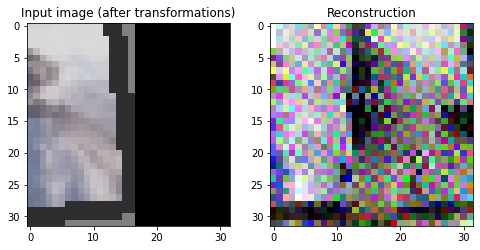

On to the figures and tables of our report for some real results!


In [6]:
attack_log = utils.load_attack_log(
    dataset="cifar100",
    model="resnet20",
    policy=[[1, 2, 3]],
    img_idx=0,
    optimizer="inversed",
)
print(f"Here's the information we store about attacks:\n{attack_log.keys()}")
print("reconstruction_stats:", attack_log["reconstruction_stats"].keys())
print("\nAnd here's the comparison between the input image and its reconstruction.")

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].set(title="Input image (after transformations)")
axs[1].set(title="Reconstruction")
axs[0].imshow(torchvision.utils.make_grid(attack_log["original_img"]).permute(1, 2, 0))
axs[1].imshow(
    torchvision.utils.make_grid(attack_log["reconstruction"]).permute(1, 2, 0)
)
plt.show()
print("On to the figures and tables of our report for some real results!")

---
# Figures & tables from our report
Here are the figures and tables that were used in our report. 


# Figure 1

Figure 1 as in original work (with our data)


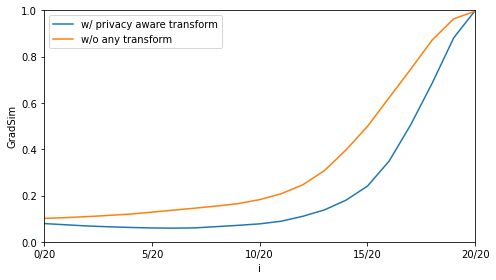

Figure 1 with mean & std fill


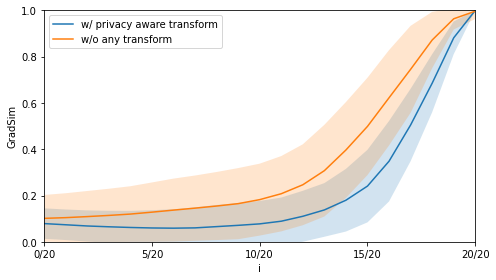

In [7]:
def config_ax(ax):
    bins = 20
    x_ticks = list(range(0, bins + 1, 5))
    ax.set(
        xlabel="i",
        ylabel="GradSim",
        xticks=x_ticks,
        xticklabels=[f"{i}/{bins}" for i in x_ticks],
        xlim=[x_ticks[0], x_ticks[-1]],
        ylim=[0, 1],
    )
    ax.legend()

s_pris, all_policies, num_images = utils.read_all_spris(
    dataset="cifar100", model="resnet20"
)
image_idxs = list(range(num_images))

# Lower S_pri score is better
best_policy = all_policies[s_pris.argmin()]
# E.g.:
# worst_policy = all_policies[s_pris.argmax()]

best_policy_grad_sims = utils.read_grad_sims(
    model="resnet20", dataset="cifar100", policy=best_policy, image_idxs=image_idxs
)
no_policy_grad_sims = utils.read_grad_sims(
    model="resnet20", dataset="cifar100", policy=None, image_idxs=image_idxs
)
best_mean, best_std = np.mean(best_policy_grad_sims, axis=0), np.std(
    best_policy_grad_sims, axis=0
)
no_mean, no_std = np.mean(no_policy_grad_sims, axis=0), np.std(
    no_policy_grad_sims, axis=0
)

print("Figure 1 as in original work (with our data)")
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(best_mean, label="w/ privacy aware transform")
ax.plot(no_mean, label="w/o any transform")
config_ax(ax)
fig.tight_layout()
plt.show()

print("Figure 1 with mean & std fill")
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(best_mean, label="w/ privacy aware transform")
ax.fill_between(
    range(len(best_mean)), best_mean + best_std, best_mean - best_std, alpha=0.2
)
ax.plot(no_mean, label="w/o any transform")
ax.fill_between(range(len(no_mean)), no_mean + no_std, no_mean - no_std, alpha=0.2)
config_ax(ax)
fig.tight_layout()
plt.show()

# Figure 2

In each subfigure:
Row 1 shows the original, clean samples.
Row 2 shows reconstructed samples from a model without any augmentations applied.
Row 3 shows an augmented image.
Row 4 shows its reconstruction from a model that was trained using these augmentations.
a) CIFAR100 with ResNet20


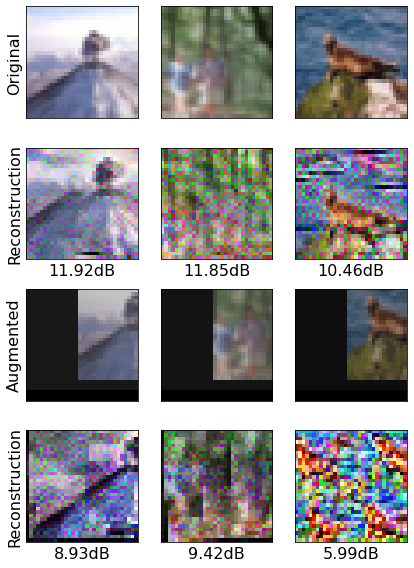

b) CIFAR100 with ConvNet


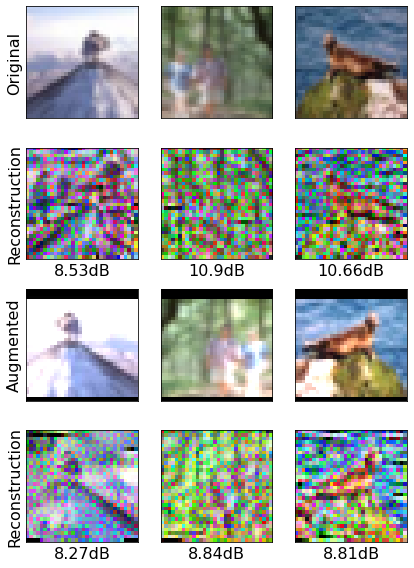

c) F-MNIST with ResNet20


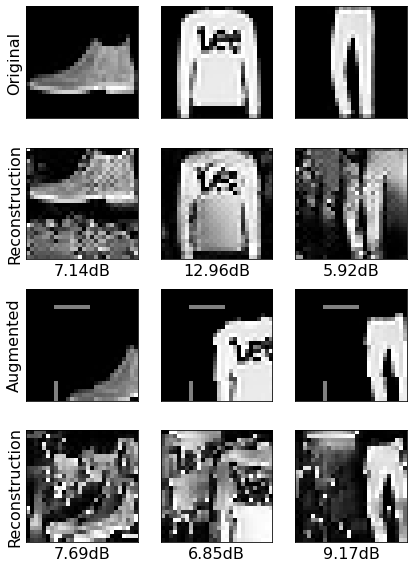

d) F-MNIST with ConvNet


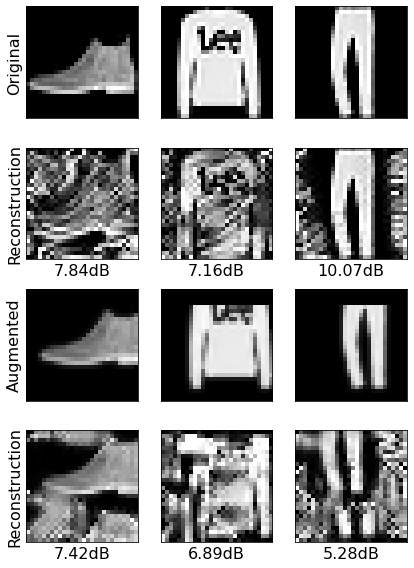

In [8]:
optimizer = "inversed"
dataset_model_combinations = [
    ("cifar100", "resnet20"),
    ("cifar100", "convnet"),
    ("fmnist", "resnet20"),
    ("fmnist", "convnet"),
]
policies = {
    dataset_model_combinations[0]: [[3, 1, 7], [43, 18, 18]],
    dataset_model_combinations[1]: [[21, 13, 3], [7, 4, 15]],
    dataset_model_combinations[2]: [[19, 15, 45], [2, 43, 21]],
    dataset_model_combinations[3]: [[42, 28, 42], [14, 48, 48]],
}

print(
    """In each subfigure:
Row 1 shows the original, clean samples.
Row 2 shows reconstructed samples from a model without any augmentations applied.
Row 3 shows an augmented image.
Row 4 shows its reconstruction from a model that was trained using these augmentations."""
)

img_idx_start = 0
subfignames = ["a", "b", "c", "d"]
for subfig, (dataset, model) in zip(subfignames, dataset_model_combinations):
    model_ui = model.title().replace("net", "Net")
    dataset_ui = dataset.upper().replace("FM", "F-M")
    print(f"{subfig}) {dataset_ui} with {model_ui}")
    fig, axs = plt.subplots(4, 3, figsize=(6, 8))
    for ax, img_idx in zip(range(3), range(img_idx_start, img_idx_start + 3)):
        log_none = utils.load_attack_log(dataset, model, [[]], img_idx, optimizer)
        log_policy = utils.load_attack_log(
            dataset, model, policies[(dataset, model)], img_idx, optimizer
        )
        axs[0][ax].imshow(
            torchvision.utils.make_grid(log_none["original_img"]).permute(1, 2, 0)
        )
        axs[1][ax].imshow(
            torchvision.utils.make_grid(log_none["reconstruction"]).permute(1, 2, 0)
        )
        axs[1][ax].set_xlabel(str(round(log_none["psnr"], 2)) + "dB", fontsize=16)

        axs[2][ax].imshow(
            torchvision.utils.make_grid(log_policy["original_img"]).permute(1, 2, 0)
        )
        axs[3][ax].imshow(
            torchvision.utils.make_grid(log_policy["reconstruction"]).permute(1, 2, 0)
        )
        axs[3][ax].set_xlabel(str(round(log_policy["psnr"], 2)) + "dB", fontsize=16)
    axs[0][0].set_ylabel("Original", fontsize=16)
    axs[1][0].set_ylabel("Reconstruction", fontsize=16)
    axs[2][0].set_ylabel("Augmented", fontsize=16)
    axs[3][0].set_ylabel("Reconstruction", fontsize=16)
    for ax in axs.flatten():
        ax.set(xticks=[], xticklabels=[], yticks=[], yticklabels=[])
    fig.tight_layout()
    plt.show()

# Figure 3

This figure presents accuracy for training and validation sets of resnet20 model on cifar data. With and without transformation (transformation chosen was: 43-18-18, as in paper it's not mentioned). Also, the same plot but for losses is presented.

In [9]:
logdir = Path("logs")
dataset = "cifar100"
model = "resnet20"

without_augs_logpath = (
    logdir
    / f"{dataset}-{model}"
    / "training"
    / "none"  # No augmentations
    / "lightning_logs"
    / "version_0"
    / "events.out.tfevents.1643583791.stefan-pc-manjaro.1263496.0"
)
with_augs_logpath = (
    logdir
    / f"{dataset}-{model}"
    / "training"
    / "43-18-18"  # Policy with augmentations 43, 18 and 18 (in that order)
    / "lightning_logs"
    / "version_0"
    / "events.out.tfevents.1643612489.stefan-pc-manjaro.1328353.0"
)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


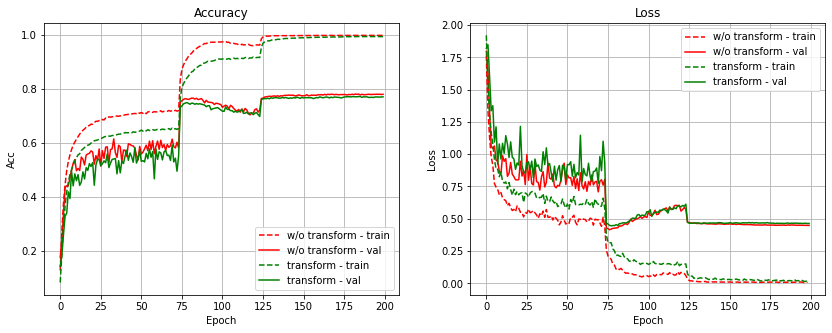

In [10]:
stats = {
    'without_augs': utils.load_stats_from_tfevents(without_augs_logpath),
    'with_augs': utils.load_stats_from_tfevents(with_augs_logpath)
}

fig, axs = plt.subplots(1, 2, figsize=(14,5))

axs[0].set(title='Accuracy', ylabel='Acc', xlabel='Epoch')
axs[0].plot(stats['without_augs']["acc"]["train"], color='r', linestyle='--', label='w/o transform - train')
axs[0].plot(stats['without_augs']["acc"]["val"], color='r', label='w/o transform - val')
axs[0].plot(stats['with_augs']["acc"]["train"], color='g', linestyle='--', label='transform - train')
axs[0].plot(stats['with_augs']["acc"]["val"], color='g', label='transform - val')

axs[1].set(title='Loss', ylabel='Loss', xlabel='Epoch')
axs[1].plot(stats['without_augs']['loss']['train'], color='r', linestyle='--', label='w/o transform - train')
axs[1].plot(stats['without_augs']['loss']['val'], color='r', label='w/o transform - val')
axs[1].plot(stats['with_augs']['loss']['train'], color='g', linestyle='--', label='transform - train')
axs[1].plot(stats['with_augs']['loss']['val'], color='g', label='transform - val')

for ax in axs:
    ax.legend()
    ax.grid()

# Figure 4

PSNR on displayed attack experiments

| Policy   |   PSNR |
|----------|--------|
| None     |  11.30 |
| Random   |  11.85 |
| Searched |   6.50 |
Shallow layers
Deeper layers


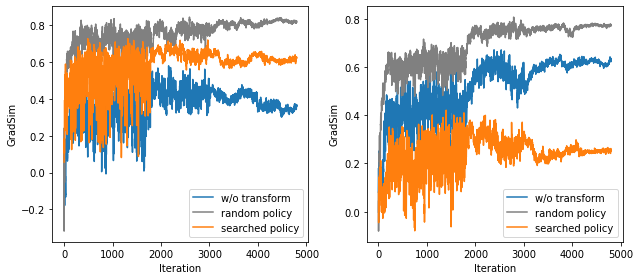

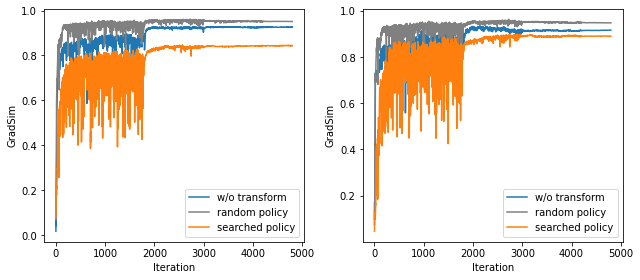

In [11]:
# Reconstruction stats are available from attack logs on image 5 and up.
img_idx = 5
log_none = utils.load_attack_log(
    "cifar100", "resnet20", policy=[[]], img_idx=5, optimizer="inversed"
)
log_random = utils.load_attack_log(
    "cifar100", "resnet20", policy=[[19, 1, 18]], img_idx=5, optimizer="inversed"
)
log_searched = utils.load_attack_log(
    "cifar100", "resnet20", policy=[[3, 1, 7]], img_idx=5, optimizer="inversed"
)

print("PSNR on displayed attack experiments\n")
print(
    tabulate(
        [
            ["None", log_none["psnr"]],
            ["Random", log_random["psnr"]],
            ["Searched", log_searched["psnr"]],
        ],
        headers=["Policy", "PSNR"],
        tablefmt="github",
        floatfmt=".2f",
    )
)


# The following module names differ from those used in the paper because we reimplemented the models
# with the exact same modules, but with only a single property `layers` holding them all.
print("Shallow layers")
shallow_layers = [
    "layers.3.0.conv1.weight",
    "layers.3.1.conv1.weight",
]
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
for name, ax in zip(shallow_layers, axs.flatten()):
    ax.set(xlabel="Iteration", ylabel="GradSim")
    ax.plot(
        log_none["reconstruction_stats"]["grad_sim_per_module"][name],
        color="tab:blue",
        label="w/o transform",
    )
    ax.plot(
        log_random["reconstruction_stats"]["grad_sim_per_module"][name],
        color="gray",
        label="random policy",
    )
    ax.plot(
        log_searched["reconstruction_stats"]["grad_sim_per_module"][name],
        color="tab:orange",
        label="searched policy",
    )
    ax.legend()
fig.tight_layout()

print("Deeper layers")
deeper_layers = [
    "layers.5.1.conv2.weight",
    "layers.5.2.conv2.weight",
]
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
for name, ax in zip(deeper_layers, axs.flatten()):
    ax.set(xlabel="Iteration", ylabel="GradSim")
    ax.plot(
        log_none["reconstruction_stats"]["grad_sim_per_module"][name],
        color="tab:blue",
        label="w/o transform",
    )
    ax.plot(
        log_random["reconstruction_stats"]["grad_sim_per_module"][name],
        color="gray",
        label="random policy",
    )
    ax.plot(
        log_searched["reconstruction_stats"]["grad_sim_per_module"][name],
        color="tab:orange",
        label="searched policy",
    )
    ax.legend()
fig.tight_layout()

# Figure 5

Figure 5 in our paper was sourced from the original work.

# Figure 6

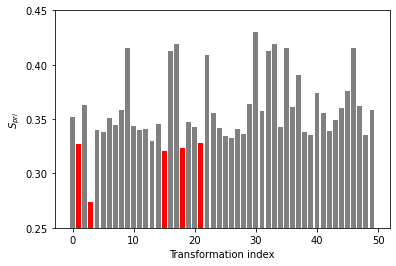

Top 5 transformations: [1, 3, 15, 18, 21]


In [12]:
single_policies_idx = [i for i, p in enumerate(all_policies) if len(p) == 1]
transformation_spri = [[] for _ in range(len(single_policies_idx))]
for i in single_policies_idx:
    policy = all_policies[i]
    policy_spri = s_pris[i]
    for t in policy:
        transformation_spri[t].append(policy_spri)
transformation_spri = [np.mean(t) for t in transformation_spri]
num_trans = len(transformation_spri)
transformation_spri = np.array(transformation_spri)
best_5 = transformation_spri.argsort()[:5]
colors = [("r" if i in best_5 else "gray") for i in range(num_trans)]

fig, ax = plt.subplots()
ax.bar(range(num_trans), transformation_spri, color=colors)
ax.set(
    xlabel="Transformation index",
    ylabel="$S_{pri}$",
    ylim=[0.25, 0.45],
    yticks=np.linspace(0.25, 0.45, 5),
)
plt.show()
print("Top 5 transformations:", sorted(best_5))

# Figure 7

Number of datapoints: 100
Pearson Correlation Coefficient:  0.12267198157821751
No correlation


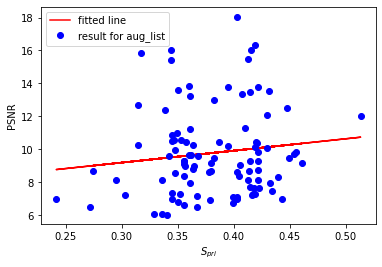

In [13]:
dataset = "cifar100"
model = "resnet20"
img_idx = 0
optimizer = "inversed"

# Load values from policy search
policy_results_dir = Path("logs/cifar100-resnet20/augmentations")
s_pri_results, pnsr_results = {}, {}
for policy in conf.selected_random_policies:
    with open(str(policy_results_dir / (policy + ".json")), "r") as f:
        loaded_results = json.load(f)
        s_pri_results[policy] = np.mean(loaded_results["S_pri"])
    psnr = utils.read_psnr(
            dataset, model, utils.split_augmentations(policy), img_idx, optimizer
        )
    pnsr_results[policy] = psnr

print("Number of datapoints:", len([v for v in pnsr_results.values() if v != 0]))
available_keys = [k for k in pnsr_results.keys() if pnsr_results[k] != 0]

pearson_correlation_coeff_legend = [
    (0.9, "Complete correlation"),
    (0.7, "Strong correlation"),
    (0.5, "Moderate correlation"),
    (0.3, "Somewhat correlated"),
    (0, "No correlation"),
]

# Fit with polyfit
x = [s_pri_results[aug] for aug in available_keys]
y = [pnsr_results[aug] for aug in available_keys]
b, m = polyfit(x, y, 1)
pearson_coeff = np.corrcoef(x, y)[0, 1]
print("Pearson Correlation Coefficient: ", pearson_coeff)
for legend in pearson_correlation_coeff_legend:
    if legend[0] <= pearson_coeff:
        print(legend[1])
        break

fig, ax = plt.subplots()
ax.plot(x, b + m * np.array(x), 'r-', label="fitted line")
ax.plot(x, y, 'bo', label = "result for aug_list")
ax.set(xlabel='$S_{pri}$', ylabel='PSNR')
ax.legend()
plt.show()

# Table 1

In [14]:
def read_stats(
    dataset: str,
    model: str,
    aug_list: List[List[int]],
    img_idx: int,
    optimizer: str,
):
    try:
        psnr = utils.read_psnr(dataset, model, aug_list, img_idx, optimizer)
        acc = utils.read_acc(dataset, model, aug_list)
    except FileNotFoundError:
        psnr = utils.read_psnr(dataset, model, reversed(aug_list), img_idx, optimizer)
        acc = utils.read_acc(dataset, model, reversed(aug_list))
    return psnr, acc

dataset_model_combinations = [
    ("cifar100", "resnet20"),
    ("cifar100", "convnet"),
    ("fmnist", "resnet20"),
    ("fmnist", "convnet"),
]
augs_lookup = {
    dataset_model_combinations[0]: [[[3, 1, 7]], [[43, 18, 18]]],
    dataset_model_combinations[1]: [[[21, 13, 3]], [[7, 4, 15]]],
    dataset_model_combinations[2]: [[[19, 15, 45]], [[2, 43, 21]]],
    dataset_model_combinations[3]: [[[42, 28, 42]], [[14, 48, 48]]],
}
none_policy, random_policy = [[]], [[19, 1, 18]]
table_names = ["a", "b", "c", "d"]
img_count = 6
for (dataset, model), table_name in zip(dataset_model_combinations, table_names):
    table = []
    unique_1, unique_2 = augs_lookup[(dataset, model)]
    hybrid_policy = [unique_1[0], unique_2[0]]
    for policy in [none_policy, random_policy, unique_1, unique_2, hybrid_policy]:
        _, acc = read_stats(
            dataset, model, aug_list=policy, img_idx=0, optimizer="inversed"
        )
        psnrs = []
        for img_idx in range(0, img_count):
            psnr, _ = read_stats(
                dataset, model, aug_list=policy, img_idx=img_idx, optimizer="inversed"
            )
            psnrs.append(psnr)
        table.append(
            [
                'Random' if policy == random_policy else 
                utils.join_augmentations(policy).title()
                if len(policy) == 1
                else "Hybrid",
                np.mean(psnrs),
                np.std(psnrs),
                acc,
            ]
        )
    model_ui = model.title().replace('net', 'Net')
    dataset_ui = dataset.upper().replace('FM', 'F-M')
    print(f"{table_name}) {dataset_ui} with {model_ui}")
    print(
        tabulate(
            table, headers=["Policy", "PSNR mean", "PSNR std", "Acc"], floatfmt='.2f', tablefmt="github"
        )
    )
    print("")

a) CIFAR100 with ResNet20
| Policy   |   PSNR mean |   PSNR std |   Acc |
|----------|-------------|------------|-------|
| None     |       12.15 |       2.06 | 78.11 |
| Random   |        9.92 |       1.93 | 75.02 |
| 3-1-7    |        6.77 |       0.88 | 71.59 |
| 43-18-18 |        9.34 |       1.81 | 77.16 |
| Hybrid   |        8.25 |       1.64 | 77.47 |

b) CIFAR100 with ConvNet
| Policy   |   PSNR mean |   PSNR std |   Acc |
|----------|-------------|------------|-------|
| None     |       11.44 |       2.93 | 72.97 |
| Random   |       10.29 |       1.02 | 71.93 |
| 21-13-3  |        8.23 |       2.18 | 63.26 |
| 7-4-15   |       10.31 |       2.14 | 70.77 |
| Hybrid   |        9.89 |       1.47 | 68.91 |

c) F-MNIST with ResNet20
| Policy   |   PSNR mean |   PSNR std |   Acc |
|----------|-------------|------------|-------|
| None     |        9.81 |       4.41 | 95.19 |
| Random   |       10.06 |       2.04 | 95.19 |
| 19-15-45 |        8.26 |       0.37 | 92.44 |
| 2-43-21 

# Table 2

In [15]:
model = "resnet20"
dataset = "cifar100"
img_count = 6
table = []
policy = [[]]
defenses = {
    "prune-70": "Pruning (70%)",
    "prune-95": "Pruning (95%)",
    "prune-99": "Pruning (99%)",
    "laplacian-0.001": "Laplacian ($10^{-3}$)",
    "laplacian-0.01": "Laplacian ($10^{-2}$)",
    "gaussian-0.001": "Gaussian ($10^{-3}$)",
    "gaussian-0.01": "Gaussian ($10^{-2}$)"
}
for defense in defenses:
    acc = utils.read_acc(dataset, model, [[]], defense)
    psnrs = []
    for img_idx in range(img_count):
        psnrs.append(
            utils.read_psnr(
                model="resnet20",
                dataset="cifar100",
                optimizer="inversed",
                img_idx=img_idx,
                policy=policy,
                defense=defense,
            )
        )
    table.append([defenses[defense], np.mean(psnrs), np.std(psnrs), acc])

print(
    tabulate(
        table,
        headers=["Defense", "PSNR mean", "PSNR std", "Acc"],
        floatfmt=".2f",
        tablefmt="github",
    )
)

| Defense               |   PSNR mean |   PSNR std |   Acc |
|-----------------------|-------------|------------|-------|
| Pruning (70%)         |       11.62 |       2.18 | 74.61 |
| Pruning (95%)         |       10.41 |       1.32 | 67.91 |
| Pruning (99%)         |        9.96 |       0.57 | 53.43 |
| Laplacian ($10^{-3}$) |       10.73 |       1.02 | 71.45 |
| Laplacian ($10^{-2}$) |       12.03 |       0.79 | 26.20 |
| Gaussian ($10^{-3}$)  |       12.11 |       2.98 | 72.89 |
| Gaussian ($10^{-2}$)  |       12.13 |       1.14 | 36.25 |


# Table 3

In [16]:
# This maps the names of the attack optimization schemes to the way they are named in the paper.
attacks = {
    "zhu": "LBFGS+L2",
    "inversed": "Adam+Cosine",
    "inversed-LBFGS-sim": "LBFGS+Cosine",
    "inversed-adam-L1": "Adam+L1",
    "inversed-adam-L2": "Adam+L2",
    "inversed-sgd-sim": "SGD+Cosine",
}
img_count = 6
table = []
for optimizer in attacks:
    none, hybrid = [], []
    for img_idx in range(img_count):
        try:
            none.append(
                utils.read_psnr(
                    dataset="cifar100",
                    model="resnet20",
                    policy=[[]],
                    img_idx=img_idx,
                    optimizer=optimizer,
                )
            )
        except FileNotFoundError:
            print("Missing (none):", optimizer)
        try:
            hybrid.append(
                utils.read_psnr(
                    dataset="cifar100",
                    model="resnet20",
                    policy=[[3, 1, 7], [43, 18, 18]],
                    img_idx=img_idx,
                    optimizer=optimizer,
                )
            )
        except FileNotFoundError:
            print("Missing (hybrid):", optimizer)
    table.append(
        [
            attacks[optimizer],
            np.mean(none),
            np.std(none),
            np.mean(hybrid),
            np.std(hybrid),
        ]
    )

print(
    tabulate(
        table,
        tablefmt="github",
        floatfmt=".2f",
        headers=[
            "Attack",
            "None - PSNR mean",
            "None - PSNR std",
            "Hybrid - PSNR mean",
            "Hybrid - PSNR std",
        ],
    )
)

| Attack       |   None - PSNR mean |   None - PSNR std |   Hybrid - PSNR mean |   Hybrid - PSNR std |
|--------------|--------------------|-------------------|----------------------|---------------------|
| LBFGS+L2     |               8.61 |              1.22 |                 6.33 |                2.00 |
| Adam+Cosine  |              12.15 |              2.06 |                 8.25 |                1.64 |
| LBFGS+Cosine |               9.62 |              0.91 |                 7.47 |                0.25 |
| Adam+L1      |               9.48 |              0.71 |                 6.43 |                0.16 |
| Adam+L2      |               9.28 |              0.69 |                 6.46 |                0.21 |
| SGD+Cosine   |              12.60 |              2.07 |                 8.03 |                1.47 |


# Table 4

In [17]:
img_count = 6
dataset_model_combinations = [
    ("fmnist", "resnet20"),
    ("fmnist", "convnet"),
]
augs_lookup = {
    dataset_model_combinations[0]: [[[3, 1, 7]], [[43, 18, 18]]],
    dataset_model_combinations[1]: [[[21,13,3]], [[7, 4, 15]]],
}
none_policy = [[]]
table_names = ["a", "b"]
for (dataset, model), table_name in zip(dataset_model_combinations, table_names):
    table = []
    unique_1, unique_2 = augs_lookup[(dataset, model)]
    hybrid_policy = [unique_1[0], unique_2[0]]
    for policy in [none_policy, unique_1, unique_2, hybrid_policy]:
        _, acc = read_stats(
            dataset, model, aug_list=policy, img_idx=0, optimizer="inversed"
        )
        psnrs = []
        for img_idx in range(0, img_count):
            psnr, _ = read_stats(
                dataset, model, aug_list=policy, img_idx=img_idx, optimizer="inversed"
            )
            psnrs.append(psnr)
        table.append(
            [
                'Random' if policy == random_policy else 
                utils.join_augmentations(policy).title()
                if len(policy) == 1
                else "Hybrid",
                np.mean(psnrs),
                np.std(psnrs),
                acc,
            ]
        )
    model_ui = model.title().replace('net', 'Net')
    dataset_ui = dataset.upper().replace('FM', 'F-M')
    print(f"{table_name}) {dataset_ui} with {model_ui}")
    print(tabulate(table, headers=["Policy", "PSNR mean", "PSNR std", "Acc"], floatfmt=".2f", tablefmt='github'))
    print("")

Table 4

a) F-MNIST with ResNet20
| Policy   |   PSNR mean |   PSNR std |   Acc |
|----------|-------------|------------|-------|
| None     |        9.81 |       4.41 | 95.19 |
| 3-1-7    |        9.30 |       2.72 | 93.20 |
| 43-18-18 |       10.03 |       2.23 | 94.88 |
| Hybrid   |        7.49 |       1.57 | 94.49 |

b) F-MNIST with ConvNet
| Policy   |   PSNR mean |   PSNR std |   Acc |
|----------|-------------|------------|-------|
| None     |        9.52 |       3.27 | 94.61 |
| 21-13-3  |        9.99 |       2.12 | 92.38 |
| 7-4-15   |        9.34 |       1.62 | 94.35 |
| Hybrid   |       11.50 |       5.80 | 93.77 |



# Bonus extension

In [18]:
img_count = 6
none = [[]]
unique_1, unique_2 = [[[3, 1, 7]], [[43, 18, 18]]]
hybrid = [unique_1[0], unique_2[0]]
table = []
for policy in [none, unique_1, unique_2, hybrid]:
    psnrs = []
    for img_idx in range(img_count):
        try:
            psnrs.append(
                utils.read_psnr(
                    model="resnet20",
                    dataset="cifar100",
                    optimizer="inversefed-default",
                    img_idx=img_idx,
                    policy=policy,
                )
            )
        except:
            print(f"Missing {img_idx}")
            pass
    table.append(
        [
            utils.join_augmentations(policy).title() if len(policy) == 1 else "Hybrid",
            np.mean(psnrs),
            np.std(psnrs),
        ]
    )
print("CIFAR100 with ResNet20")
print(
    tabulate(
        table,
        headers=["Policy", "PSNR mean", "PSNR std"],
        floatfmt=".2f",
        tablefmt="github",
    )
)

CIFAR100 with ResNet20
| Policy   |   PSNR mean |   PSNR std |
|----------|-------------|------------|
| None     |       15.39 |       2.78 |
| 3-1-7    |        8.47 |       0.85 |
| 43-18-18 |       10.97 |       1.06 |
| Hybrid   |        8.95 |       0.90 |


# Extension: Policy Search on Tiny ImageNet 200

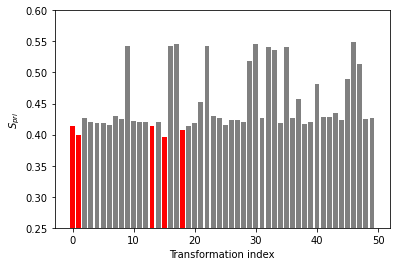

Top 5 transformations: [0, 1, 13, 15, 18]


In [19]:
policy_results_d = Path("logs/tiny-imagenet200-resnet20/augmentations")
spri = []
all_policies = [
    list(map(int, p.stem.split("-"))) for p in policy_results_d.glob("*[0-9].json")
]
for policy in all_policies:
    policy_results_f = policy_results_d / f"{'-'.join(map(str, policy))}.json"
    with open(policy_results_f) as f:
        policy_results = json.load(f)
    spri.append(policy_results["S_pri"])
num_images = len(spri[0])
image_ids = list(range(num_images))
spri = np.mean(spri, axis=1)
single_policies_idx = [i for i, p in enumerate(all_policies) if len(p) == 1]
transformation_spri = [[] for _ in range(len(single_policies_idx))]
for i in single_policies_idx:
    policy = all_policies[i]
    policy_spri = spri[i]
    for t in policy:
        transformation_spri[t].append(policy_spri)
transformation_spri = [np.mean(t) for t in transformation_spri]
num_trans = len(transformation_spri)
transformation_spri = np.array(transformation_spri)
best_5 = transformation_spri.argsort()[:5]
colors = [("r" if i in best_5 else "gray") for i in range(num_trans)]

fig, ax = plt.subplots()
ax.bar(range(num_trans), transformation_spri, color=colors)
ax.set(
    xlabel="Transformation index",
    ylabel="$S_{pri}$",
    ylim=[0.25, 0.6],
    yticks=np.linspace(0.25, 0.6, 8),
)
plt.show()
print("Top 5 transformations:", sorted(best_5))

# Extension: Training and attacking ResNet20 on Tiny ImageNet 200

In [20]:
img_count = 6
dataset = "tiny-imagenet200"
model = "resnet20"
none_policy = [[]]
hybrid_policy = [[3, 1, 7], [43, 18, 18]]

none_tfevents_path = "logs/tiny-imagenet200-resnet20/training/none/lightning_logs/version_8726848/events.out.tfevents.1643938128.stefan-pc-manjaro.1749599.0"

table = []
for policy in [none_policy, hybrid_policy]:
    if policy == none_policy:
        acc = utils.load_stats_from_tfevents(none_tfevents_path)["acc"]["val"][-1] * 100
    else:
        _, acc = read_stats(
        dataset, model, aug_list=policy, img_idx=0, optimizer="inversed"
    )
    psnrs = []
    for img_idx in range(0, img_count):
        psnr, _ = read_stats(
            dataset, model, aug_list=policy, img_idx=img_idx, optimizer="inversed"
        )
        psnrs.append(psnr)
    table.append(
        [
            "Random"
            if policy == random_policy
            else utils.join_augmentations(policy).title()
            if len(policy) == 1
            else "Hybrid",
            np.mean(psnrs),
            np.std(psnrs),
            acc,
        ]
    )
    model_ui = model.title().replace("net", "Net")
    dataset_ui = dataset.title()
print(f"{dataset_ui} with {model_ui}")
print(
    tabulate(
        table,
        headers=["Policy", "PSNR mean", "PSNR std", "Acc"],
        floatfmt=".2f",
        tablefmt="github",
    )
)
print("")

Tiny-Imagenet200 with ResNet20
| Policy   |   PSNR mean |   PSNR std |   Acc |
|----------|-------------|------------|-------|
| None     |        8.96 |       1.25 | 61.44 |
| Hybrid   |        7.92 |       0.79 | 57.38 |

